## Step 1: Fetch the real world data

- DATA FROM JSON TO CSV


In [30]:

import json
import requests
import codecs
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.datasets import make_blobs

# fetching data from file, parsing the json
data = None
file = '../data/location1.json'
with open(file, "r") as read_file:
    data = json.load(codecs.open(file, 'r', 'utf-8-sig'))

coord = []

# preprocessing the data
for line in data:
    coord.append(line['geometry']['coordinates']) 
    
new = []
for line in coord:
    for points in line:
        new.append(points)
        
# Isolating the dependencies
new_coord = np.unique(np.array(coord),axis=0)
new_coord.shape
dat = pd.DataFrame(new_coord, columns=['x','y'])
dat.to_csv("real_housing_data_x_y.csv")

#### Defining our constants and variables

In [16]:
# seed for consistent results
RANDOM_SEED = 32
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
NUM_HOUSES = len(dat)

MEAN_DEMAND_WATER_PER_HOUSE = 100 # LITERS
VAR_DEMAND_WATER_PER_HOUSE = 50 # LITERS

# This can be evaluated using the vision api
MEAN_AREA_PER_HOUSE = 100 # METERS SQUARE
VAR_AREA_PER_HOUSE = 50 # METERS SQUARE PER HOUSE

RAINFALL_ESTIMATE = 100 # mm
FC_TANK_PLACEMENT = 10000 # Rs.
FIXED_COST_PIPE_PER_METER = 120 # Rs.
COST_PER_LITERS_TANK = 500 # Rs.

## Data to save and feed to algorithm

In [64]:
house_data_x = dat['x'].values
house_data_y = dat['y'].values

# demand
demand_per_house = np.array([np.random.normal(loc = MEAN_DEMAND_WATER_PER_HOUSE, scale = VAR_DEMAND_WATER_PER_HOUSE) for i in range(NUM_HOUSES)])

#area
area_per_house = np.array([np.random.normal(loc = MEAN_AREA_PER_HOUSE, scale = VAR_AREA_PER_HOUSE) for i in range(NUM_HOUSES)])

# rainfall estimation
rainfall_estimate_for_city =  np.array([RAINFALL_ESTIMATE for i in range(NUM_HOUSES)]) # FLOAT

# capacity of the tanks per house (DERIVED)
capacity_for_tank_per_house = np.array([area_per_house[i]* RAINFALL_ESTIMATE/1000  for i in range(NUM_HOUSES)])

# average_length_of_pipe_per_house
average_length_of_pipe_per_house = np.random.normal(loc = 30, scale = 40, size = NUM_HOUSES)

# fixed_cost_of_tank_placement_per_house
fixed_cost_of_tank_placement_per_house = np.array([FC_TANK_PLACEMENT for i in range(NUM_HOUSES)])

# cost_per_liters_tank
cost_per_liters_tank_per_house = np.array([COST_PER_LITERS_TANK for i in range(NUM_HOUSES)])


In [66]:
print('House_data_x', (house_data_x.shape) )
print('House_data_y', (house_data_y.shape))
print('Demand_per_house', (demand_per_house.shape))
print('Capacity_for_tank_per_house', (capacity_for_tank_per_house.shape))
print('Rainfall_estimate_for_city', (rainfall_estimate_for_city.shape))
print('Average_length_of_pipe_per_house', (average_length_of_pipe_per_house.shape))
print('fixed_cost_of_tank_placement_per_house', (fixed_cost_of_tank_placement_per_house.shape))
print('cost_per_liters_tank_per_house', (cost_per_liters_tank_per_house.shape))


House_data_x (1111,)
House_data_y (1111,)
Demand_per_house (1111,)
Capacity_for_tank_per_house (1111,)
Rainfall_estimate_for_city (1111,)
Average_length_of_pipe_per_house (1111,)
fixed_cost_of_tank_placement_per_house (1111,)
cost_per_liters_tank_per_house (1111,)


## A visual representation of our data

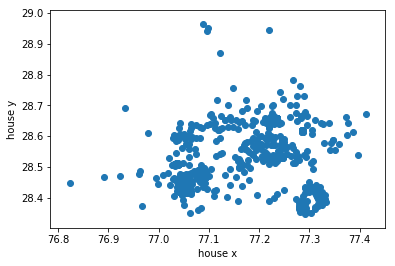

In [23]:
# sns.scatterplot(house_data_x, house_data_y, hue = house_data_labels)
# plt.figure(figsize = (12,12))
plt.scatter(x= house_data_x, y= house_data_y )
plt.xlabel("house x")
plt.ylabel("house y")
plt.show()


In [67]:
df = pd.DataFrame(data = None, columns = None)
df['house_data_x'] = house_data_x
df['house_data_y'] = house_data_y
df['demand_per_house_liters'] = demand_per_house
df['area_per_house_metersq'] = area_per_house
df['capacity_for_tank_per_house_lt'] = capacity_for_tank_per_house
df['rainfall_estimate_for_city_mm'] = rainfall_estimate_for_city
df['average_length_of_pipe_per_house'] = average_length_of_pipe_per_house
df['fixed_cost_of_tank_placement_per_house'] = fixed_cost_of_tank_placement_per_house
df['cost_per_liters_tank_per_house'] = cost_per_liters_tank_per_house


df = df.round(3)
df.head()

,house_data_x,house_data_y,demand_per_house_liters,area_per_house_metersq,capacity_for_tank_per_house_lt,rainfall_estimate_for_city_mm,average_length_of_pipe_per_house,fixed_cost_of_tank_placement_per_house,cost_per_liters_tank_per_house
0,76.824,28.447,68.870,85.958,8.596,100,42.717,10000,500
1,76.892,28.468,130.274,126.353,12.635,100,24.552,10000,500
2,76.923,28.472,121.357,-11.073,-1.107,100,68.078,10000,500
3,76.933,28.690,174.917,113.416,11.342,100,66.364,10000,500
4,76.961,28.476,48.527,80.773,8.077,100,8.051,10000,500


In [68]:
df.to_csv("data.csv", index= False, header=True)

Generating or getting the data for the tanks:

- Web App allows us to pip point the map and get the generated data in csv format

## Working with the tanks data
- Real data
- Taken directly from our web app


Column names are Lat, Lng, Id, Address
Processed 60 lines.
(59, 2)


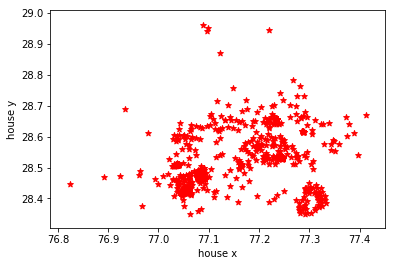

In [154]:
import csv

tank_data_from_website = []
with open('tank_loc_website.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            x = row[0]
            y = row[1]
            tank_data_from_website.append([x,y])
            line_count += 1
    print(f'Processed {line_count} lines.')

tank_data_from_website = np.array(tank_data_from_website)
print(tank_data_from_website.shape)
                  
NUM_TANKS = len(tank_data_from_website)

tanksdf = pd.DataFrame(data = None, columns = None)
tanksdf['tanks_x'] = tank_data_from_website[:,1]
tanksdf['tanks_y'] = tank_data_from_website[:,0]
tanksdf = tanksdf.round(3)
tanksdf.to_csv("tanks_loc.csv", index = False, header = True)

plt.scatter(x= house_data_x, y= house_data_y, c = 'red', marker = '*' )
plt.xlabel("house x")
plt.ylabel("house y")
plt.show()

MIN_X = min(tank_data_from_website[:,1])
MIN_Y = min(tank_data_from_website[:,0])
                  
# plt.scatter((tank_data_from_website[:,1]),(tank_data_from_website[:,0]), color = 'green', marker="*" )
# plt.xlabel("tank x")
# plt.ylabel("tank y")
# plt.show()
                  
                  

In [111]:
# NUM_TANKS = len(tank_data_from_website)

# tank_locator = np.array([random.random() for _ in range(NUM_HOUSES)])

# # get the 50 nodes with max values and their index
# idx = (-tank_locator).argsort()[:NUM_TANKS]
# tank_data_x, tank_data_y = house_data_x[idx], house_data_y[idx]

# tanksdf = pd.DataFrame(data = None, columns = None)
# tanksdf['tanks_x'] = tank_data_x
# tanksdf['tanks_y'] = tank_data_y
# tanksdf = tanksdf.round(3)
# tanksdf.to_csv("tanks_loc.csv", index = False, header = True)

# Solution 1: Clustering

In [152]:
tanks = pd.read_csv("tanks_loc.csv")
houses = pd.read_csv("data.csv")

print(houses.head(3))
print()
print(tanks.head(3))

   house_data_x  house_data_y  demand_per_house_liters  \
0        76.824        28.447                   68.870   
1        76.892        28.468                  130.274   
2        76.923        28.472                  121.357   

   area_per_house_metersq  capacity_for_tank_per_house_lt  \
0                  85.958                           8.596   
1                 126.353                          12.635   
2                 -11.073                          -1.107   

   rainfall_estimate_for_city_mm  average_length_of_pipe_per_house  \
0                            100                            42.717   
1                            100                            24.552   
2                            100                            68.078   

   fixed_cost_of_tank_placement_per_house  cost_per_liters_tank_per_house  
0                                   10000                             500  
1                                   10000                             500  
2            

In [120]:
# defining the variables
NUM_TANKS = len(tanks)
NUM_HOUSES = len(houses)
print('Number of tanks and houses are: ',NUM_TANKS, NUM_HOUSES )

# FOR EVERY HOUSE AND TANK, ASSIGN EVERY HOUSE A NEAREST TANK BASED ON THE CLUSTER

# CREATING 2D ARRAY OF TANKS
tanks_houses = [[] for j in range(NUM_TANKS)]

for i in range(len(houses)):
    # LOC OF HOUSE
    hx, hy = houses.house_data_x.iloc[i],houses.house_data_y.iloc[i]
    min_dist_from_house_to_tank = np.inf
    min_dist_tank = None
    hx*=1000
    hy*=1000
    
    for j in range(len(tanks)):
        # LOC OF TANKS
        tx, ty = tanks.tanks_x.iloc[j], tanks.tanks_y.iloc[j]
        
        # converting lat long to the actual distance based coordinates
        # can be optimised
        
        tx*=1000
        ty*=1000
        
#         print(tx,ty, hx, hy)
        # DIST ~ APPROX ~ EUCLIDIAN DISTANCE
        dist = np.sqrt( (ty- hy)**2 + (tx- hx)**2)
        
        if dist<min_dist_from_house_to_tank:
            min_dist_from_house_to_tank = dist
            min_dist_tank = j
            
    tanks_houses[min_dist_tank].append(i) # appending the house
    
print('houses clustered to tanks')
tank_index = 0
for x in tanks_houses[:]:
    print('Tank index = {0}'.format(tank_index),'\nhouses:',x)
    print()
    tank_index+=1

Number of tanks and houses are:  59 1111
houses clustered to tanks
Tank index = 0 
houses: [740, 744, 771, 773, 780, 785, 789, 790, 793, 796, 797, 798, 800, 802, 804, 814, 815, 818, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 903, 908, 933]

Tank index = 1 
houses: [1006, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1033, 1034, 1035, 1036, 1037, 1039, 1040, 1041, 1058, 1067, 1068]

Tank index = 2 
houses: [631, 637, 717, 719, 723, 736, 739, 742]

Tank index = 3 
houses: [728, 749, 783, 803, 807, 813]

Tank index = 4 
houses: [991, 992, 999, 1001, 1016, 1017, 1032, 1051]

Tank index = 5 
houses: [775, 806, 812, 922, 983]

Tank index = 6 
houses: [997, 1005, 1014, 1045]

Tank index = 7 
houses: [3]



## Calculating the capacity and where not to place tanks

In [122]:
# ASSUMING THE DATA FOR CIJ
def calculate_capacity_of_tanks(tanks_houses):
    capacity_of_jth_tank = []
    for j in range(len(tanks_houses)):
        houses_tank = tanks_houses[j]
        capacity = np.sum(houses_tank)
        capacity_of_jth_tank.append(capacity)
    return capacity_of_jth_tank
capacity_of_jth_tank= calculate_capacity_of_tanks(tanks_houses)
print('capacity of jth tank(10 tanks here)',capacity_of_jth_tank[:10]) 
print()
print()
print('tanks with no capacity(no houses connected) are:', [tank for tank in range(len(capacity_of_jth_tank)) if capacity_of_jth_tank[tank]<=0])


capacity of jth tank(10 tanks here) [69893, 24800, 5644, 4683, 8099, 4298, 4061, 3, 2929, 32520]


tanks with no capacity(no houses connected) are: [16, 19, 21, 26, 27, 28, 29, 34, 38, 39, 40, 42, 47, 49, 52, 54, 55, 56, 57]


Main step is to calculate the CIJ,tie the cost of pipe from i'th house to j'th tank

- can be optimised
- moving forward with the assumptions

In [123]:
# CIJ CALCULATION
FIXED_COST_OF_PIPES_PER_METER = 120
CIJ = [[0 for i in range(NUM_TANKS)] for j in range(NUM_HOUSES)]
print(np.array(CIJ).shape) # TODO

for i in range(NUM_HOUSES):
    hx, hy = houses.house_data_x.iloc[i],houses.house_data_y.iloc[i]
    hx*=1000
    hy*=1000
    for j in range(NUM_TANKS):
        tx, ty = tanks.tanks_x.iloc[j], tanks.tanks_y.iloc[j]
        
        tx*=1000
        ty*=1000
        dist = np.sqrt( (ty- hy)**2 + (tx- hx)**2)
        
        CIJ[i][j]= dist*FIXED_COST_OF_PIPES_PER_METER

CIJ = np.array(CIJ)


(1111, 59)


In [127]:
cost_of_setting_jth_tank = []
for j in range(len(tanks_houses)):
    houses_linked_to_tank = tanks_houses[j]
    cost = 0
    if capacity_of_jth_tank[j] >0: 
        cost = houses.cost_per_liters_tank_per_house[j]
    else :
        cost = 0
        
    for house_index in (houses_linked_to_tank):
        cost += CIJ[house_index][j]
    
    cost_of_setting_jth_tank.append(cost)
        
# zip(cost_of_setting_jth_tank) # TODO
cost_of_setting_jth_tank

In [132]:
# giving the data to the backend of our web application
import numpy as np
import codecs, json 

List = [{} for j in range(NUM_TANKS)]

for j in range(NUM_TANKS):
    List[j]['x'] = tanks['tanks_x'].iloc[j].astype('float32')
    List[j]['y'] = tanks['tanks_y'].iloc[j].astype('float32')
    List[j]['stability'] = 1.00
    List[j]['capacity'] = capacity_of_jth_tank[j].astype('float32')
    List[j]['cost_of_making'] = cost_of_setting_jth_tank[j]
    
temp = pd.DataFrame(List)
temp.head()

,capacity,cost_of_making,stability,x,y
0,69893.0,287532.357522,1.0,77.216827,28.632629
1,24800.0,33156.539722,1.0,77.279205,28.617981
2,5644.0,18051.621525,1.0,77.170906,28.655077
3,4683.0,17203.990915,1.0,77.205238,28.682152
4,8099.0,31677.967204,1.0,77.293045,28.698713


### Tanks that should not be constructed

In [133]:
print('tanks with no capacity(no houses connected) are:', [tank for tank in range(len(capacity_of_jth_tank)) if capacity_of_jth_tank[tank]==0])

tanks with no capacity(no houses connected) are: [16, 19, 21, 26, 27, 28, 29, 34, 38, 39, 40, 42, 47, 49, 52, 54, 55, 56, 57]


## JSON passed to backend of the website

In [134]:
values = temp.values
print(json.dumps(values.tolist())) # TODO 
# FINAL

[[69893.0, 287532.3575215386, 1.0, 77.21682739257812, 28.63262939453125], [24800.0, 33156.53972157293, 1.0, 77.27920532226562, 28.61798095703125], [5644.0, 18051.621524956514, 1.0, 77.17090606689453, 28.65507698059082], [4683.0, 17203.99091499548, 1.0, 77.20523834228516, 28.682151794433594], [8099.0, 31677.967204401935, 1.0, 77.29304504394531, 28.698713302612305], [4298.0, 19627.99681427577, 1.0, 77.20343780517578, 28.70722007751465], [4061.0, 16602.13402825839, 1.0, 77.30089569091797, 28.732440948486328], [3.0, 1276.936263016557, 1.0, 76.92693328857422, 28.692262649536133], [2929.0, 24143.139853955603, 1.0, 77.09990692138672, 28.55617904663086], [32520.0, 170102.81276134058, 1.0, 77.17236328125, 28.54266929626465], [96098.0, 178114.09524587623, 1.0, 77.24085235595703, 28.5439510345459], [15657.0, 49562.0407895929, 1.0, 77.24222564697266, 28.568828582763672], [7000.0, 19544.021768074792, 1.0, 77.25544738769531, 28.558425903320312], [5145.0, 15186.56598961537, 1.0, 77.26925659179688, 28